In [1]:
# Here you can 
# 1. Extract Features and save
# 2. Transform features
# 3. Load transformed features for training
# 4. Train 
# 5. Evaluate

In [2]:
from final_utils import *

# generate root path
root_path = generate_root_path() 

###  Feature extraction

#### Multigap feature extraction

In [3]:
# creating model
model_mg = model_inceptionresnet_multigap()

In [ ]:
# extracting train good image multigap features and saving with .json
source_file = root_path + 'Data/splitted/train/images/good/good1'
target_file = root_path + 'Data/splitted/train/features/mg/original/'

extract_features_from_path_automated_json(
                                     source_file=source_file,
                                     target_file=target_file,
                                     label='good',
                                     splitted='good1',
                                     model=model_mg,
                                     resize_func=False,
                                     save_json=True)

In [ ]:
# extracting train bad image multigap features and saving with .json
target_file = root_path + 'Data/splitted/train/features/multigap/original/'

for i in range(7):
    paths = root_path + f'Data/splitted/train/images/bad/bad{i+1}'
    extract_features_from_path_automated_json(
                                     source_file=paths,
                                     target_file=target_file,
                                     label='bad', 
                                     splitted=f'bad{i+1}',
                                     model=model_mg,
                                     resize_func=False,
                                     save_json=True)

#### CNN feature ctraction

In [6]:
# creating model
model_cnn = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",trainable=False) ])

In [ ]:
# extracting train good image cnn features and saving
source_file = root_path + 'Data/splitted/train/images/good/good1'
target_file = root_path + 'Data/splitted/train/features/cnn_efficientnet_b7/border_600x600/'

extract_features_from_path_automated_json(
                                     source_file=source_file,
                                     target_file=target_file,
                                     label='good',
                                     splitted='good1',
                                     model=model_cnn, 
                                     resize_func=resize_add_border,
                                     size=(600, 600),
                                     save_json=False)

In [ ]:
# extracting train bad image cnn features and saving
target_file = root_path + 'Data/splitted/train/features/cnn_efficientnet_b7/border_600x600/'

for i in range(7):
    paths = root_path + f'Data/splitted/train/images/bad/bad{i+1}'
    extract_features_from_path_automated_json(
                                     source_file=paths,
                                     target_file=target_file,
                                     label='bad', 
                                     splitted=f'bad{i+1}',
                                     model=model_cnn, 
                                     resize_func=resize_add_border,
                                     size=(600, 600),
                                     save_json=False)

### Dimentionality reduction

#### For multigap features

In [14]:
# loading feature vectors from paths
paths = glob(f'{root_path}Data/splitted/train/features/mg/original/*')
feator_vectors = []
for path in paths:
    feator_vectors.append(np.load(path))
feator_vectors = np.asarray(feator_vectors)
feator_vectors = np.squeeze(feator_vectors,axis = 1)
print(feator_vectors.shape)    

(96, 16928)


In [26]:
# repeats need for PCA model fit
feator_vectors = np.repeat(feator_vectors, 200, axis=0)

In [27]:
# creating model PCA and training
pca_mg = PCA(n_components = 8464 , svd_solver = "auto")
pca_mg.fit(feator_vectors)#

PCA(n_components=8464)

In [28]:
# making directores for saving transformed features and pca model
transformed_feats_path = f'{root_path}Data/splitted/train/features/mg/original_PCA_8464_auto'
pca_mg_path = 'models/PCA'

if not os.path.exists(transformed_feats_path):
    os.mkdir(transformed_feats_path)
if not os.path.exists(pca_mg_path):
    os.mkdir(pca_mg_path)

In [29]:
# saving pca model
pk.dump(pca_mg, open(f'{pca_mg_path}/PCA_MG_8464_auto.pkl', 'wb'))

In [30]:
# saving transformed features
for path in paths:
    basename = (os.path.basename(path).split('.'))[0]
    feat = np.load(path)
    feat = pca_mg.transform(feat)
    np.save(os.path.join(transformed_feats_path, basename), feat)

#### For cnn features

In [31]:
# loading feature vectors from paths
paths = glob(f'{root_path}Data/splitted/train/features/cnn_efficientnet_b7/border_600x600/*')
feator_vectors = []
for path in paths:
    feator_vectors.append(np.load(path))
feator_vectors = np.asarray(feator_vectors)
feator_vectors = np.squeeze(feator_vectors,axis = 1)
print(feator_vectors.shape)    

(96, 2560)


In [32]:
# repeats need for PCA model fit
feator_vectors = np.repeat(feator_vectors, 30, axis=0)

In [33]:
# creating model PCA and training
pca_cnn = PCA(n_components = 1280 , svd_solver = "auto")
pca_cnn.fit(feator_vectors)

PCA(n_components=1280)

In [34]:
# making directores for saving transformed features and pca model
transformed_feats_path = f'{root_path}Data/splitted/train/features/cnn_efficientnet_b7/border_600x600_PCA_1280_auto'
pca_cnn_path = 'models/PCA'
if not os.path.exists(transformed_feats_path):
    os.mkdir(transformed_feats_path)
if not os.path.exists(pca_cnn_path):
    os.mkdir(pca_cnn_path)

In [35]:
# saving pca model
pk.dump(pca_cnn, open(f'{pca_cnn_path}/PCA_CNN_1280_auto.pkl', 'wb'))

In [36]:
# saving transformed features
for path in paths:
    basename = (os.path.basename(path).split('.'))[0]
    feat = np.load(path)
    feat = pca_cnn.transform(feat)
    np.save(os.path.join(transformed_feats_path, basename), feat)

### Training FC

In [37]:
# define loss function
SC_CE_KLD = tf.keras.losses.SparseCategoricalCrossentropy()

In [38]:
# Loading cnn features and multigap features from .json
main_path = root_path + 'Data/splitted/train/'
features_bad_list = []
features_bad_list_i = []
features_good1 = []
feats_MG = 'original_PCA_8464_auto' 
feats_CNN = 'border_600x600_PCA_1280_auto'
    
for i in range(7):
    alm_train_bad = open(f'{main_path}data_bad{i+1}.json')
    bad_data = json.load(alm_train_bad)
    for data in bad_data:
        feat_path_1 = main_path + f'features/mg/{feats_MG}/' + data['feature']
        feat_path_2 = main_path + f'features/cnn_efficientnet_b7/{feats_CNN}/' + data['feature']
        connected = np.concatenate((np.squeeze(np.load(feat_path_1)), np.squeeze(np.load(feat_path_2))))
        features_bad_list_i.append(connected)
    features_bad_list.append(features_bad_list_i)
    features_bad_list_i = []
        
alm_train_good = open(f'{main_path}/data_good1.json')
good_data = json.load(alm_train_good)
for data in good_data:
    feat_path_1 = main_path + f'features/mg/{feats_MG}/' + data['feature']
    feat_path_2 = main_path + f'features/cnn_efficientnet_b7/{feats_CNN}/' + data['feature']
    connected = np.concatenate((np.squeeze(np.load(feat_path_1)), np.squeeze(np.load((feat_path_2)))))
    features_good1.append(connected)
    
for i in range(7):
    features_bad_list[i] = np.squeeze(np.array(features_bad_list[i]))
features_good1 = np.squeeze(np.array(features_good1))
   
# Generating static validation data
features_bad_list[0], features_bad1_val = extract_static_val_data(features_bad_list[0], perc = 0.11)
features_good1, features_good1_val = extract_static_val_data(features_good1, perc = 0.11)

bad = features_bad_list

In [39]:
# Creating validation data
X_val = np.concatenate((features_bad1_val, features_good1_val) , axis=0 )
y_val = np.concatenate((np.zeros(len(features_bad1_val)), np.ones(len(features_good1_val))), axis=0 )

In [40]:
# trainer
def trainer(model, data, weights_path, data_val,batch_size=128, epochs=30, learning_rate=0.03):
    X_train, X_test, y_train, y_test = data

    model.compile(loss=SC_CE_KLD,
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, 
                                                  epsilon=1e-07, decay=0, amsgrad=False))
    model.load_weights(weights_path) 
    checkpoint = keras.callbacks.ModelCheckpoint(weights_path, 
                                                 monitor='val_loss', 
                                                 verbose=1, 
                                                 save_best_only=True, 
                                                 mode='min')
    schedule = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=0)
    callbacks_list = [checkpoint, schedule]

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        callbacks=callbacks_list,
                        validation_data = data_val)

    return history

In [41]:
# creating fc model and weights
model_fc = fc_model_softmax(input_num=9744)
weights_path = f'models/model_fc_softmax.hdf5' #path where will save model weights
model_fc.save_weights(weights_path) #if we want to cancel learning and start from 0, if not comment the line
model_fc.load_weights(weights_path)

In [42]:
# defining epochs count, batch size and learning rate
epochs = 15
batch_size = 128
learning_rate = 0.003

### Attention !!! in block below the counter "i" must be changed manualy

In [44]:
data_val = (X_val, y_val)

i =  # Set i the nesseccary one, as we take a pair of one good and one bad (from 7)
data = get_train_pairs(bad[i], features_good1, train_size=0.95, shuffle=True)
if True:
    history = trainer(model_fc, data, weights_path, data_val, batch_size, epochs, learning_rate=learning_rate)
    acc = calc_acc(model_fc, weights_path, data_val[0], data_val[1], batch_size)
    print('----- Accuracy =', acc, '%', ' -----')
    print('---Batch Train Done---')

train_data_bad shape (12, 9744)
train_data_good shape (11, 9744)
Epoch 1/15
1/1 [==============================] - ETA: 0s - loss: 0.1010
Epoch 1: val_loss improved from inf to 0.09239, saving model to models\model_fc_softmax.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.1010 - val_loss: 0.0924 - lr: 0.0030
Epoch 2/15
1/1 [==============================] - ETA: 0s - loss: 0.0233
Epoch 2: val_loss did not improve from 0.09239
1/1 [==============================] - 0s 215ms/step - loss: 0.0233 - val_loss: 0.0943 - lr: 0.0029
Epoch 3/15
1/1 [==============================] - ETA: 0s - loss: 0.0097
Epoch 3: val_loss did not improve from 0.09239
1/1 [==============================] - 0s 40ms/step - loss: 0.0097 - val_loss: 0.1051 - lr: 0.0026
Epoch 4/15
1/1 [==============================] - ETA: 0s - loss: 8.4635e-04
Epoch 4: val_loss did not improve from 0.09239
1/1 [==============================] - 0s 27ms/step - loss: 8.4635e-04 - val_loss: 0.1105 - lr: 0.0022
Epoch 

### Evaluation on benchmark_1 and benchmark_2

In [45]:
# Loading fc weights
model_fc.load_weights(weights_path)

In [46]:
# Loading pca models, if need
pca_mg = pk.load(open(f'{pca_mg_path}/PCA_MG_8464_auto.pkl', 'rb'))
pca_cnn = pk.load(open(f'{pca_cnn_path}/PCA_CNN_1280_auto.pkl', 'rb'))

In [72]:
# Loading paths of benchmark datas
good_imgs_path = glob(os.path.join(root_path, 'Data', 'benchmark', 'images', 'good', '*'))
bad_imgs_path = glob(os.path.join(root_path, 'Data', 'benchmark', 'images', 'bad', '*'))

good_imgs_path_2 = glob(os.path.join(root_path, 'Data','benchmark2', 'images', 'good', '*'))
bad_imgs_path_2 = glob(os.path.join(root_path, 'Data', 'benchmark2', 'images', 'bad', '*'))

# Creating labels of loaded benchmark data paths
paths_bench = good_imgs_path + bad_imgs_path
labels_bench = np.concatenate((np.ones(len(good_imgs_path)), np.zeros(len(bad_imgs_path))))

paths_bench_2 = good_imgs_path_2 + bad_imgs_path_2
labels_bench_2 = np.concatenate((np.ones(len(good_imgs_path_2)), np.zeros(len(bad_imgs_path_2))))

In [48]:
# Some necessary functions for prediction
def predict(x, y=None, model_gap=None, model=None, model_cnn=None, is_norm=False, pca_mg=None, pca_cnn = None):
    '''
    Does prediction on given numpy image using
    model_gap and model
    '''
    try:
        feat_mg = model_gap.predict(x, verbose=0)
    except:
        x = x[None] #changed 02.08 for evaluator visualizing predictions
        feat_mg = model_gap.predict(x, verbose=0)
        
    if pca_mg:
        feat_mg = pca_mg.transform(feat_mg)
    if model_cnn:
        feat_cnn = model_cnn.predict(y, verbose=0)
        if is_norm:
            feat_cnn = normalize_feat_vector(feat_cnn)
        if pca_cnn:
            feat_cnn = pca_cnn.transform(feat_cnn)
        feat = np.concatenate((np.squeeze(feat_mg), np.squeeze(feat_cnn)))
        feat = feat[None]
    else:
        feat = feat_mg
    pred_score = model.predict(feat, verbose=0)

    return pred_score
    
def predict_from_path(model_gap, model, paths, resize_func=None, size=None, for_all=False, save_results=None, 
                      save_to=None, model_cnn=None, is_norm=False, pca_mg = None, pca_cnn = None):
    #always requires list of paths
    predicted = []
    
    for i, path in enumerate(paths):
        img_mg = read_img(path=path, resize_func=resize_func, size=size, for_all=True)
        img_cnn = None
        if model_cnn:
            img_cnn = read_img(path=path, resize_func=resize_add_border, size=(600, 600))
        pred_score = predict(img_mg, img_cnn, model_gap, model, model_cnn, is_norm, pca_mg, pca_cnn)
        predicted.append(pred_score)
    
    predicted = np.array(predicted)
    predicted = np.squeeze(predicted)
    
    if save_results:
        np.save(save_to, np.argmax(predicted, axis=-1))
        
    return predicted

def plot_pred_orig(model_gap, model, imgs_bench, label=None, row_count=2, column_count=10, resize_func=None, size=None, for_all=False, model_cnn=None, is_norm=False, pca_mg=None, pca_cnn=None):
    f, axarr = plt.subplots(row_count, column_count,  figsize=(20,5))

    for i, path in enumerate(imgs_bench):
        x = i // column_count
        y = i % column_count

        img_mg = read_img(path, resize_func=resize_func, size=size, for_all=for_all)
        
        img_cnn = None
        if model_cnn:
            img_cnn = read_img(path=path, resize_func=resize_add_border, size=(600, 600))
            
        pred_score = predict(img_mg, img_cnn, model_gap, model, model_cnn, is_norm, pca_mg, pca_cnn)

        im = cv2.imread(path)
        im = cv2.resize(im, (400, 400))
        
        if row_count == 1:
            axarr[i].imshow(im[..., ::-1]) 
            axarr[i].set_title(f'{str(np.argmax(pred_score, axis=-1)[0])}\n{str(np.round(np.max(pred_score, axis=-1),3)[0])}', fontsize=12)
        else:
            axarr[x, y].imshow(im[..., ::-1]) 
            axarr[x, y].set_title(f'{str(np.argmax(pred_score, axis=-1)[0])}\n{str(np.round(np.max(pred_score, axis=-1),3)[0])}', fontsize=12)

    if label:
        f.suptitle('test on ' + label, fontsize=17)
    else: 
        f.suptitle('Predictions', fontsize=17)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.show()

def calc_acc(labels, predicted):
    '''
    Calculating mean class error, e.g. predicted classes are 1vs0, 0vs0, 0vs0, 0vs0, then we have acc=0.25
    Inputs: 
        labels = target labels
        predicted = predicted binary probability distribution for the input
    Output:
        mean class error
    '''
    acc = np.sum(np.array(labels) == np.argmax(np.array(predicted), axis=1)) / len(labels)
    return np.round(acc * 100, 2)

#### Prediction on benchmark_1

In [49]:
#resize_max (996, 996) means if images' height or width > 996 then resize with maximum 996 and another with aspect ratio
predicted = predict_from_path(model_mg, model_fc, paths_bench, resize_func=resize_max, size=(996, 996), for_all=False,
                              model_cnn=model_cnn, is_norm=False, pca_mg=pca_mg, pca_cnn=pca_cnn)

In [50]:
# Calc accuracy
acc = calc_acc(labels_bench, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 69.72 %


In [51]:
# Precision and Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(labels_bench, pred)

Precision: 63.04 %
Recall: 64.44 %


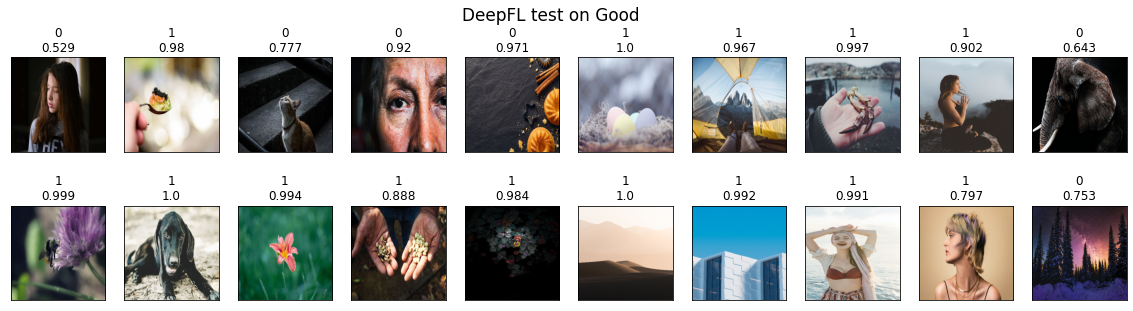

In [66]:
# Visualizing 
data_size = 20
plot_pred_orig(model_mg, model_fc, good_imgs_path[:data_size], resize_func=resize_max, 
               label='Good', size=(996, 996), model_cnn=model_cnn, pca_mg=pca_mg, pca_cnn=pca_cnn)

#### Prediction on benchmark_2

In [74]:
predicted = predict_from_path(model_mg, model_fc, paths_bench_2, resize_func=resize_max, size=(996, 996), for_all=False,
                              model_cnn=model_cnn, is_norm=False, pca_mg=pca_mg, pca_cnn=pca_cnn)

In [75]:
# Calc accuracy
acc = calc_acc(labels_bench_2, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 66.34 %


In [77]:
# Precision and Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(labels_bench_2, pred)

Precision: 67.88 %
Recall: 66.1 %


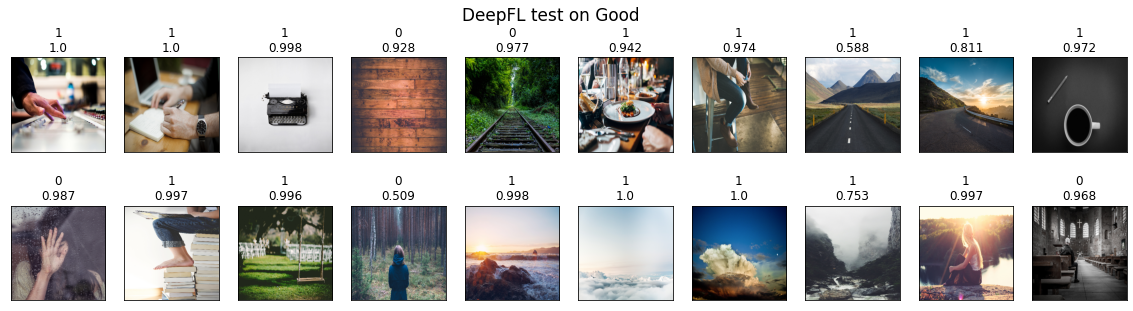

In [79]:
# Visualizing 
data_size = 20
plot_pred_orig(model_mg, model_fc, good_imgs_path_2[:data_size], resize_func=resize_max, 
               label='Good', size=(996, 996), for_all=True, model_cnn=model_cnn, pca_mg=pca_mg, pca_cnn=pca_cnn)